## Compressive Sensing 

This notebooks consider a compressive sensing problem:

$$
\arg min_\mathbf{x}  = \frac{1}{2} \|\mathbf{Ax}-\mathbf{y}\|_2^2 + \lambda \|\mathbf{x}\|_1  
$$

where the matrix $\mathbf{A}$ is a randomized sampling matrix. 

We investigate here the scenario where the matrix $A$ is dense and can be explicitely factorized via Cholesky factorization and used in subsequent operations when computing the proximal of the L2 operator. We will see that this 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pylops
import pyproximal

In [2]:
n, m = 40, 100
mava = 10

# model
x = np.zeros(m)
iava = np.random.permutation(np.arange(m))[:mava]
x[iava] = np.random.normal(0, 1, mava)

# operator
A = np.random.normal(0, 1, (n, m))
Aop = pylops.MatrixMult(A)
y = Aop * x

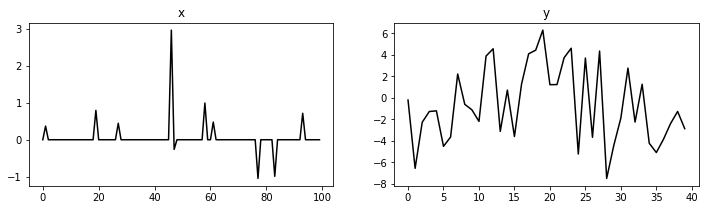

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].set_title('x')
axs[1].plot(y, 'k')
axs[1].set_title('y');

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 3.695369e-03	niter = 1000

   Itn       x[0]          f           g       J = f + g
     1   2.86492e-02   1.169e+02   4.503e+00   1.214e+02
     2   3.80500e-02   6.384e+01   6.764e+00   7.060e+01
     3   4.37891e-02   3.750e+01   8.500e+00   4.600e+01
     4   4.56051e-02   2.441e+01   9.608e+00   3.402e+01
     5   4.55050e-02   1.703e+01   1.040e+01   2.743e+01
     6   4.43818e-02   1.255e+01   1.095e+01   2.350e+01
     7   4.22089e-02   9.676e+00   1.140e+01   2.107e+01
     8   3.95088e-02   7.751e+00   1.169e+01   1.944e+01
     9   3.66166e-02   6.346e+00   1.192e+01   1.827e+01
    10   3.36395e-02   5.291e+00   1.211e+01   1.740e+01
   101  -3.19770e-06   6.109e-01   1.061e+01   1.122e+01
   201  -6.43438e-06   5.386e-01   9.492e+00   1.003e+01
   301   1.05860e-05   4.639e-01   8.891e+00 

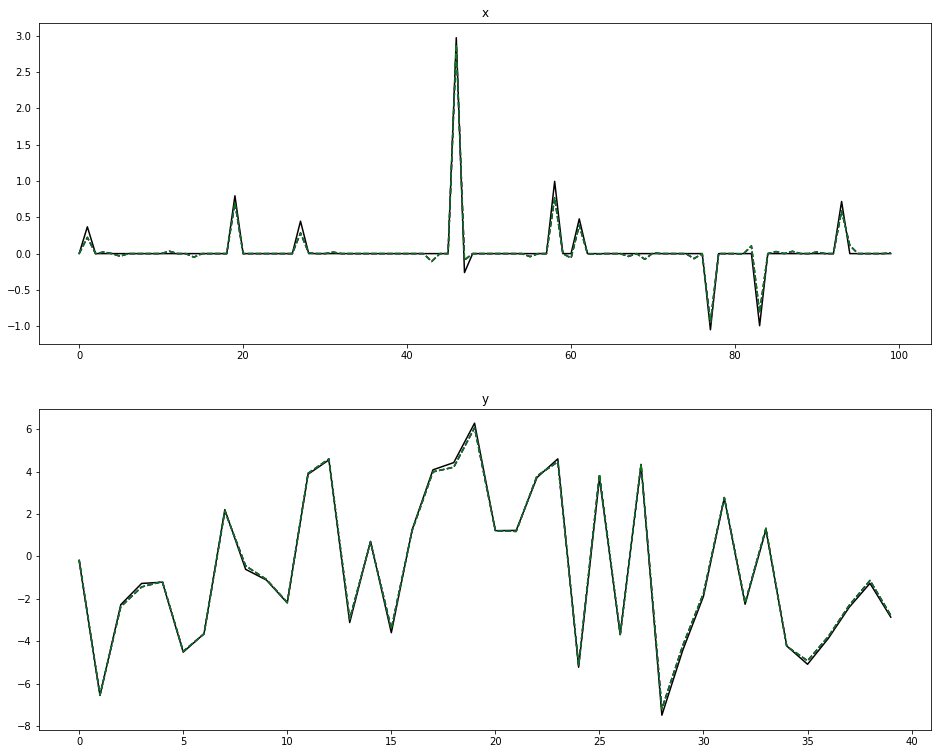

In [5]:
f = pyproximal.L2(Aop, y, niter=20)
f1 = pyproximal.L2(Aop, y, densesolver='scipy')
f2 = pyproximal.L2(Aop, y, densesolver='factorize')
g = pyproximal.L1()

ATA = Aop.H * Aop
ATA.explicit = False
L = np.abs(ATA.eigs(1)[0])
#L = np.abs((Aop.H * Aop).eigs(1)[0])
niter = 1000
tau= 0.95/L

xinv = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                           tau,  niter=niter, show=True)[0]

xinv1 = pyproximal.optimization.primal.ADMM(f1, g, np.zeros_like(x),
                                            tau, niter=niter, show=True)[0]

xinv2 = pyproximal.optimization.primal.ADMM(f2, g, np.zeros_like(x),
                                            tau, niter=niter, show=True)[0]


fig, axs = plt.subplots(2, 1, figsize=(16, 13))
axs[0].plot(x, 'k')
axs[0].plot(xinv, '--r')
axs[0].plot(xinv1, '--b')
axs[0].plot(xinv2, '--g')
axs[0].set_title('x')
axs[1].plot(y, 'k')
axs[1].plot(Aop @ xinv, '--r')
axs[1].plot(Aop @ xinv1, '--b')
axs[1].plot(Aop @ xinv2, '--g')
axs[1].set_title('y');

In [6]:
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x), tau, niter=niter)
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f1, g, np.zeros_like(x), tau, niter=niter)
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f2, g, np.zeros_like(x), tau, niter=niter)

525 ms ± 72.7 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
570 ms ± 120 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
40.3 ms ± 461 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [ ]:
np.linalg.norm(x-xinv), np.linalg.norm(x-xinv1), np.linalg.norm(x-xinv2)